In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch

class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)  # Mean
        self.fc22 = nn.Linear(hidden_dim, latent_dim)  # Log variance

        # Decoder
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [7]:
%pip install torchvision

from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # flatten the image
])

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
import torch

# Hyperparameters
input_dim = 28 * 28
hidden_dim = 400
latent_dim = 20
batch_size = 64
epochs = 3  # You can increase for better results

# DataLoader
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)

# Model and optimizer
vae = VAE(input_dim, hidden_dim, latent_dim)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

# Loss function
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Training loop
vae.train()
for epoch in range(epochs):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'Epoch {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}] Loss: {loss.item() / len(data):.4f}')
    print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')

Epoch 0 [0/60000] Loss: 548.7267
Epoch 0 [6400/60000] Loss: 181.6526
Epoch 0 [12800/60000] Loss: 147.8432
Epoch 0 [19200/60000] Loss: 148.4605
Epoch 0 [25600/60000] Loss: 143.3767
Epoch 0 [32000/60000] Loss: 127.2662
Epoch 0 [38400/60000] Loss: 126.6015
Epoch 0 [44800/60000] Loss: 128.4233
Epoch 0 [51200/60000] Loss: 126.3136
Epoch 0 [57600/60000] Loss: 117.5107
====> Epoch: 0 Average loss: 145.6658
Epoch 1 [0/60000] Loss: 114.8242
Epoch 1 [6400/60000] Loss: 119.8934
Epoch 1 [12800/60000] Loss: 120.8386
Epoch 1 [19200/60000] Loss: 120.4554
Epoch 1 [25600/60000] Loss: 114.8252
Epoch 1 [32000/60000] Loss: 116.3516
Epoch 1 [38400/60000] Loss: 111.5910
Epoch 1 [44800/60000] Loss: 105.0360
Epoch 1 [51200/60000] Loss: 112.4807
Epoch 1 [57600/60000] Loss: 113.8805
====> Epoch: 1 Average loss: 115.4825
Epoch 2 [0/60000] Loss: 114.1552
Epoch 2 [6400/60000] Loss: 109.8080
Epoch 2 [12800/60000] Loss: 110.2687
Epoch 2 [19200/60000] Loss: 105.3879
Epoch 2 [25600/60000] Loss: 122.7199
Epoch 2 [32000


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


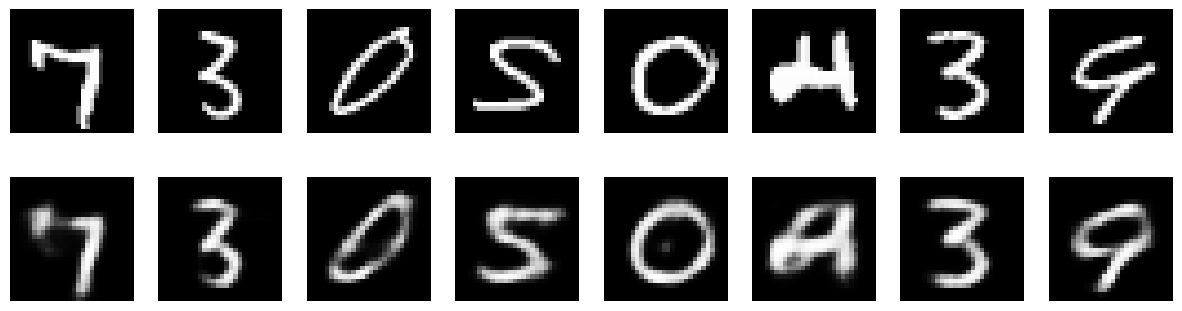

In [9]:
%pip install matplotlib
import matplotlib.pyplot as plt

vae.eval()  # Set model to evaluation mode

# Get a batch of test images
test_loader = DataLoader(mnist_test, batch_size=8, shuffle=True)
test_images, _ = next(iter(test_loader))

# Reconstruct images
with torch.no_grad():
    recon_images, _, _ = vae(test_images)

# Plot original and reconstructed images
fig, axes = plt.subplots(2, 8, figsize=(15, 4))
for i in range(8):
    axes[0, i].imshow(test_images[i].view(28, 28).cpu(), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(recon_images[i].view(28, 28).cpu(), cmap='gray')
    axes[1, i].axis('off')
axes[0, 0].set_ylabel('Original')
axes[1, 0].set_ylabel('Reconstructed')
plt.show()

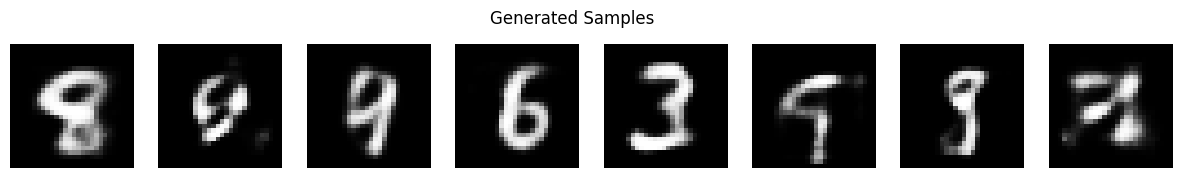

In [10]:
with torch.no_grad():
    z = torch.randn(8, latent_dim)  # 8 random latent vectors
    generated = vae.decode(z)

fig, axes = plt.subplots(1, 8, figsize=(15, 2))
for i in range(8):
    axes[i].imshow(generated[i].view(28, 28).cpu(), cmap='gray')
    axes[i].axis('off')
plt.suptitle('Generated Samples')
plt.show()

In [11]:
# Suggestions to increase privacy for non-open-source data:
# 1. Apply differential privacy techniques during training (e.g., DP-SGD).
# 2. Limit access to raw data and use secure data storage.
# 3. Anonymize or obfuscate sensitive features before training.
# 4. Use federated learning to keep data on-device.
# 5. Regularly audit and monitor data access and usage.
# 6. Remove or mask any personally identifiable information (PII) if present.
# 7. Encrypt data at rest and in transit.

In [12]:
%pip install gradio

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
import torch
import gradio as gr
import numpy as np

def generate_digit(seed=42, latent_dim=20):
    torch.manual_seed(seed)
    z = torch.randn(1, latent_dim)                      
    with torch.no_grad():                                   
        generated = vae.decode(z)                                                                                                                                                                            
    img = generated.view(28, 28).cpu().numpy()
    return img                       

gr.Interface(
    fn=generate_digit,
    inputs=gr.Slider(0, 1000, step=1, value=42, label="Random Seed"),
    outputs=gr.Image(label="Generated Digit", image_mode='L'),
    title="VAE MNIST Digit Generator",
    description="Move the slider to generate different digits from your trained VAE!"
).launch(share=True)                                                                                                                  

* Running on local URL:  http://127.0.0.1:7863
* Running on public URL: https://e4fe2e863b22b82913.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Created dataset file at: .gradio\flagged\dataset3.csv


In [14]:
import gradio as gr
import numpy as np
import torch
from PIL import Image

def reconstruct_digit(img):
    # Convert to PIL Image, resize to 28x28, then to numpy and normalize
    img = Image.fromarray(img).convert("L").resize((28, 28))
    img = np.array(img).astype(np.float32) / 255.0
    img_tensor = torch.tensor(img).view(1, 28*28)
    with torch.no_grad():
        recon, _, _ = vae(img_tensor)
    recon_img = recon.view(28, 28).cpu().numpy()
    return recon_img

gr.Interface(
    fn=reconstruct_digit,
    inputs=gr.Image(image_mode='L', sources=['upload'], label="Upload Digit"),
    outputs=gr.Image(label="Reconstructed Digit", image_mode='L'),
    title="VAE MNIST Digit Reconstructor",
    description="Upload a digit image (any size, will be resized to 28x28) to see its reconstruction by your trained VAE."
).launch(share=True)

* Running on local URL:  http://127.0.0.1:7864
* Running on public URL: https://9ab754579845324c38.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Created dataset file at: .gradio\flagged\dataset4.csv
